# Gaussian Process Non-linear Regression

In [9]:
import matplotlib
%matplotlib inline

from typing import Callable

import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set()

matplotlib.rcParams['text.usetex'] = True

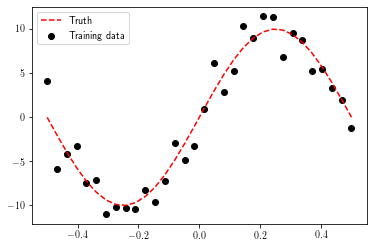

In [10]:
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10 * np.sin(2 * np.pi * (x)) + epsilon

N = 32
noise = 2.0

X = np.linspace(-0.5, 0.5, N).reshape(-1, 1)
y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)

plt.scatter(X, y, color='black', label='Training data')
plt.plot(X, y_true, label='Truth', linestyle='--', color='r')
plt.legend()
plt.show()

In [33]:
class GPRegression:
    
    def __init__(self, kernel: Callable = None, **kernel_kwargs):
        self.kernel = kernel
        self.kernel_kwargs = kernel_kwargs
        pass

    def regression(self, X: np.ndarray, y: np.ndarray, X_test: np.ndarray = None, number: int = 10,
                   kernel: Callable = None, **kernel_kwargs) -> (np.ndarray):
        if kernel is None:
            kernel = self.kernel
            kernel_kwargs = self.kernel_kwargs
        self.X, self.y, self.X_test = X, y, X_test
            
        self.K = kernel(X, X, **kernel_kwargs)
        self.L = np.linalg.cholesky(K + s*np.eye(len(X)))
        
        if X_test is not None:
            self.predict(X, y, X_test)
            return self.mu, self.var
        else:
            # return mean and var at training points
            return np.dot(self.L, np.random.normal(size=(len(X),number))), np.diag(self.K)
    
    def draw_samples_from_prior(self, X: np.ndarray, number: int = 10, 
                                kernel: Callable = None, **kernel_kwargs) -> np.ndarray:
        if kernel is None:
            kernel = self.kernel
            kernel_kwargs = self.kernel_kwargs
        K_ = kernel(X, X, **kernel_kwargs)
        L = np.linalg.cholesky(K_ + 1e-6*np.eye((len(X))))
        return L @ np.random.normal(size=(len(X),number))
    
    def draw_samples_from_posterior(self, X: np.ndarray = None, number: int = 10,
                                   kernel: Callable = None, **kernel_kwargs) -> (np.ndarray):
        if kernel is None:
            kernel = self.kernel
            kernel_kwargs = self.kernel_kwargs
        if X is None:
            X = self.X_test
        else:
            self.predict(self.X, self.y, X)
            
        L = np.linalg.cholesky(self.K_ + 1e-6*np.eye(len(X)) - np.dot(self.Lk.T, self.Lk))
        samples = self.mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(len(X),10)))
        return samples
    
    def predict(self, X: np.ndarray, y: np.ndarray, X_test: np.ndarray = None, s: float = 0.5, 
                kernel: Callable = None, **kernel_kwargs) -> (np.ndarray):
        if kernel is None:
            kernel = self.kernel
            kernel_kwargs = self.kernel_kwargs
            
        self.X, self.y, self.X_test = X, y, X_test
        
        self.K = kernel(X, X, **kernel_kwargs)
        self.L = np.linalg.cholesky(self.K + s * np.eye(len(X)))
        
        if X_test is not None:
            # compute mean at test points
            self.Lk = np.linalg.solve(self.L, kernel(X, X_test, **kernel_kwargs))
            self.mu = self.Lk.T @ np.linalg.solve(self.L, y)

            # compute variance at test points
            self.K_ = kernel(X_test, X_test, length_scale=length_scale)
            self.var = np.diag(self.K_) - np.sum(self.Lk**2, axis=0)
        else:
            # return mean and var at training points
            self.mu = np.dot(self.L, np.random.normal(size=(len(X),number)))
            self.var = np.diag(self.K)
            
        return self.mu, self.var
    
    def plot_confidence(self, X: np.ndarray = None, mu: np.ndarray = None, var: np.ndarray = None, 
                        no_std: int = 2, fname: str = None):
        if mu is None: 
            mu = self.mu
        if var is None:
            var = self.var
        if X is None:
            X = self.X_test if self.X_test is not None else self.X
        fig, ax = plt.subplots()
        ax.fill_between(X_test.flatten(), mu.flatten()-2*var, mu.flatten()+2*var, 
                        color='#6C85B6', alpha=0.2, label='Total uncertainty')
        ax.plot(X.flatten(), mu.flatten(), color='#D1895C', label='Predictive mean')
        ax.scatter(self.X, self.y, color='black', label='Training data')
        ax.set_xlabel(r'$x$', fontsize=17)
        ax.set_ylabel(r'$y$', fontsize=17)
        plt.tight_layout()
        if fname is not None:
            plt.savefig(fname, bbox_inches='tight')
        else:
            plt.show()
        pass
    
    def plot_samples(self, X: np.ndarray, samples: np.ndarray, fname: str = None):
        fig, ax = plt.subplots()
        ax.plot(X, samples)
        ax.set_xlabel(r'$x$', fontsize=17)
        ax.set_ylabel(r'$y$', fontsize=17)
        plt.tight_layout()
        if fname is not None:
            plt.savefig(fname, bbox_inches='tight')
        else:
            plt.show()
        pass

In [34]:
def sq_exp_kernel(x1: np.ndarray, x2: np.ndarray, length_scale: float = 0.05) -> np.ndarray:
    """ GP squared exponential kernel """
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * x1 @ x2.T
    return np.exp(-.5 * (1/length_scale) * sqdist)

In [38]:
n = 500
X_test = np.linspace(-1.5, 1.5, n).reshape(-1, 1)

gp_regression = GPRegression()

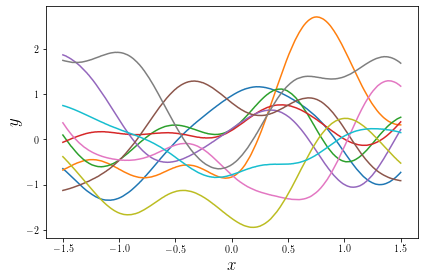

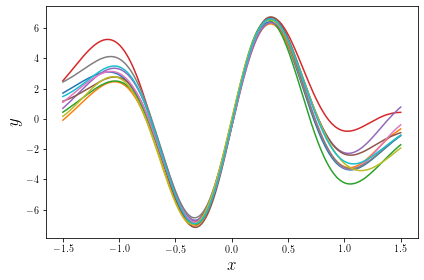

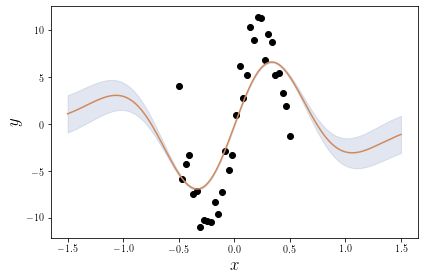

In [39]:
gp_regression.kernel = sq_exp_kernel
gp_regression.kernel_kwargs = {'length_scale': 0.2}

mu, var = gp_regression.predict(X, y, X_test)
prior_samples = gp_regression.draw_samples_from_prior(X_test)
posterior_samples = gp_regression.draw_samples_from_posterior(X_test)
gp_regression.plot_samples(X_test, prior_samples)
gp_regression.plot_samples(X_test, posterior_samples)
gp_regression.plot_confidence()